In [1]:
import os
import glob

import pandas as pd
import numpy as np
import datetime

from skimage import io
from datetime import timedelta
from datetime import datetime
from scipy.stats import pearsonr

from netCDF4 import Dataset

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
from matplotlib.dates import MonthLocator
import matplotlib.patheffects as PathEffects

### LOAD AND SET UP DATA (ARS)

In [2]:
# #base path
# base_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/'

# #data paths
# depth_3m_path = 'depths_3m/equal_extent_data_downsize/{}/*.tif'
# # mask files
# mask_3m_file = '/home/meganmason/Documents/projects/thesis/maps/map_layers/basin_ops/tuolumne/topo/basin_setup/topo.nc' #this is 3m, only TB, downloaded 8-8 with Micah
# mask_50m_file = '/home/meganmason/Documents/projects/thesis/maps/map_layers/basin_ops/tuolumne/topo/topo_50m.nc' #first topo.nc downloaded, renamed to _50m.nc
# # dem 
# dem_3m_file = 'TB20140827_snow_free_dtm_vf_3p0m.tif'

#### load/set up (mm)

In [3]:
base_path = '/Users/megmason/Desktop/'
depth_3m_path = 'equal_extent_data_downsize/{}/*.tif'
# mask_3m_file = '/Users/megmason/Desktop/topo.nc'

In [4]:
# years and flight dates (3m)
years = list(range(2014,2016)) # 2013-2018

flist = []
for year in sorted(years):
    flist_yr = glob.glob(base_path + depth_3m_path.format(year))
    flist.extend(flist_yr) #.append adds list to lists (ie multiple lists), .extend tacks on to og list (ie one list) 
print(flist)
# dates=[]
# for f in flist:
# #     print(f)
#     dt_str = f.split("/")[-1] #splits on / and saves the last one
#     dt_str = "".join([c for c in dt_str if c.isnumeric()]) #grabs numeric values
#     dt = pd.to_datetime(dt_str[:8]) #convert to datetime, grabs digits for dates only
# #     print('flight date:',dt.date())
#     dates.append(dt.date()) #.date to exclude time (00:00:00)
    
# dates = pd.to_datetime(dates) #could revisit (seems like I put it in datetime 2x, w/o here it's a class 'list')
# # print(type(date))
# # print(date)

    
# ~~~~~~~~~~~~~~ASK MICAH FOR HELP - LIST COMPREHENSION  ~~~~~~~~~~~~  
# flist = ([glob.glob(flist_yr).extend for year in years])
# print(flist)
# flist = (glob.glob(base_path + depth_3m_path.format(year)) for year in years)
# print(flist)

['/Users/megmason/Desktop/equal_extent_data_downsize/2014/20140323_SUPERsnow_depth_3m_int.tif', '/Users/megmason/Desktop/equal_extent_data_downsize/2014/20140407_SUPERsnow_depth_3m_int.tif', '/Users/megmason/Desktop/equal_extent_data_downsize/2014/20140413_SUPERsnow_depth_3m_int.tif', '/Users/megmason/Desktop/equal_extent_data_downsize/2014/20140420_SUPERsnow_depth_3m_int.tif', '/Users/megmason/Desktop/equal_extent_data_downsize/2014/20140428_SUPERsnow_depth_3m_int.tif', '/Users/megmason/Desktop/equal_extent_data_downsize/2014/20140502_SUPERsnow_depth_3m_int.tif', '/Users/megmason/Desktop/equal_extent_data_downsize/2014/20140511_SUPERsnow_depth_3m_int.tif', '/Users/megmason/Desktop/equal_extent_data_downsize/2014/20140517_SUPERsnow_depth_3m_int.tif', '/Users/megmason/Desktop/equal_extent_data_downsize/2014/20140527_SUPERsnow_depth_3m_int.tif', '/Users/megmason/Desktop/equal_extent_data_downsize/2014/20140531_SUPERsnow_depth_3m_int.tif', '/Users/megmason/Desktop/equal_extent_data_downsi

In [5]:
# function for DATETIME - kinda works?
def flight_date(f):
#     print(f)
    dt_str = f.split("/")[-1] #splits on / and saves the last one
    dt_str = "".join([c for c in dt_str if c.isnumeric()]) #grabs numeric values
    dt = pd.to_datetime(dt_str[:8]) #convert to datetime, grabs digits for dates only
#     print('flight date:',dt.date())
#         dates.append(dt.date()) #.date to exclude time (00:00:00)
    
    return dt.date() #pd.to_datetime(dt.date)

# datelist = [flight_date(f) for f in sorted(flist)] 
#print(datelist[0].strftime('%Y-%m-%d'))

#### 50m below

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~
#test with 50m lidar .tifs (use this until you get 3 meter mask - gdalme, veg data, Makefile.....)
#~~~~~~~~~~~~~~~~~~~~~~~

# path_50m_tifs = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/all/tmp/*.tif'
# flist = sorted(glob.glob(path_50m_tifs))


# path_50m_tifs = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/{}/*.tif'
# years = list(range(2013,2019)) # 2013-2018
# flist = []
# for year in sorted(years):
#     flist_yr = glob.glob(path_50m_tifs.format(year))
#     flist.extend(flist_yr) #.append adds list to lists (ie multiple lists), .extend tacks on to og list (ie one list) 
# # flist


In [ ]:
#mask checking (3m)
ds = Dataset(mask_3m_file) #using 'from netCDF4 import Dataset'
print(ds.variables.keys())
mask = ds.variables['mask'] #grab tum mask variable, use ds.variables.keys() to list all possible variables
print('mask shape:', mask.shape, 
      '\nmask value to use:', np.max(mask), 
      '\n# of pixels in mask:', np.sum(mask))
plt.imshow(mask, cmap='gray')
plt.colorbar()

### ANALYSIS..testing

In [6]:
#~~~~~~ FUNCTIONS ~~~~~~~~~~~~~~~~~~~~

def describe_lidar_data(depth_array, mask_array = None, mask_value = None):
    
    '''calculates the mean of a lidar flight -- will add more summary statistics'''
    
    if mask_array is None:
        
        sn_mean = np.nanmean(depth_array[depth_array > 0])
        sn_std  = np.nanstd(depth_array[depth_array > 0])
        sn_min  = np.nanmin(depth_array[depth_array > 0])
        sn_max  = np.nanmax(depth_array[depth_array > 0])
        column = [sn_mean, sn_std, sn_min, sn_max]
        return column
    
    else: 
        sn_mean = np.nanmean(depth_array[(mask_array == mask_value) & (depth_array > 0)])
        sn_std  = np.nanstd(depth_array[(mask_array == mask_value) & (depth_array > 0)])
        sn_min  = np.nanmin(depth_array[(mask_array == mask_value) & (depth_array > 0)])
        sn_max  = np.nanmax(depth_array[(mask_array == mask_value) & (depth_array > 0)])
        column = [sn_mean, sn_std, sn_min, sn_max]
        return column 
        #return {"mean":sn_mean, "std": sn_std, "min": sn_min, "max": sn_max}
        

In [7]:
# ~~~~~ CALL FUNCTIONS ~~~~~~~~~~~~
# depth_tum = []
df = pd.DataFrame()

for f in sorted(flist):
#     print('file:',f)
    fDate = flight_date(f)
    d = io.imread(f) #is numpy array 
#     print('type:', type(d), 'shape:', d.shape)
    #depth_tum.append(describe_lidar_data(d, mask_array = mask, mask_value=np.max(mask)))
#     column = describe_lidar_data(d, mask_array = mask, mask_value=np.max(mask))
    column = describe_lidar_data(d) #, mask_array = None, mask_value=None)
    df[fDate] = column
df = df.transpose()
df.columns = ['mean','std','min','max']
df

,mean,std,min,max
2014-03-23,112.527064,78.879837,1.0,700.0
2014-04-07,127.174471,85.533093,1.0,700.0
2014-04-13,116.429839,79.294492,1.0,700.0
2014-04-20,121.324663,83.625056,1.0,700.0
2014-04-28,105.506890,84.845108,1.0,700.0
2014-05-02,104.199230,81.186614,1.0,700.0
2014-05-11,101.218527,83.659420,1.0,700.0
2014-05-17,99.034075,94.698060,1.0,700.0
2014-05-27,86.627946,84.056118,1.0,700.0
2014-05-31,84.505207,86.567341,1.0,700.0


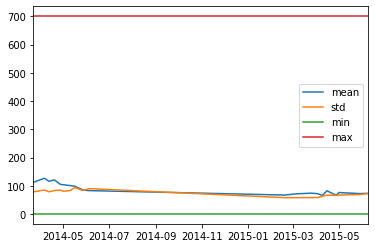

In [8]:
df.plot()

In [56]:
# Histogram Function

def histogram_df(depth_array, binx, mask_array = None, mask_value = None):
    
    ''' histogram dataframe'''
    if mask_array is None:
        hist = np.histogram(depth_array[depth_array>0], binx)
        return hist
    else: 
        hist = np.histogram(depth_array[(mask_array == mask_value) & (depth_array > 0)], binx)
        return hist
    


In [57]:
#call histogram function

df_h = pd.DataFrame()
binx = np.arange(0,1000,30)

for f in sorted(flist):
    fDate = flight_date(f)
    d = io.imread(f)
#     hist = histogram_df(d, binx, mask_array = mask, mask_value=np.max(mask))
    hist = histogram_df(d, binx) 
#     print(hist[0])
    df_h[fDate]=hist[0]
#     df_h.set_index=binx
# df=df.transpose()
# df.columns='histogram'
df_h = df_h.set_index(binx[:-1]) #index first col as left bin edges
df_h 

#save to csv!
export_csv = df_h.to_csv('/Users/megmason/Desktop/outputs/histogram_df.csv', index = None, header=True)

In [58]:
df_h

,2014-03-23,2014-04-07,2014-04-13,2014-04-20,2014-04-28,2014-05-02,2014-05-11,2014-05-17,2014-05-27,2014-05-31,...,2015-02-18,2015-03-06,2015-03-25,2015-04-03,2015-04-09,2015-04-15,2015-04-27,2015-05-01,2015-05-28,2015-06-08
0,9063857,10619604,9251924,6864484,16468369,9609206,8931042,7888594,7577341,6673697,...,22954947,23506951,12189601,9620832,37309225,10715793,26449225,8820423,8559890,3868970
30,12225367,12568574,12580394,10506080,15235979,12471667,11342092,9385949,8686070,6320918,...,20780822,23932920,14481451,11042600,32022509,11973704,17805836,8215156,7831775,2780421
60,13991041,13782558,14588733,12323324,14319858,13288906,11453602,7896250,6258951,4293229,...,15642523,19196529,12296243,8568839,17815024,9784246,10960662,6190493,4922594,1809588
90,14907760,14823546,15653023,12875599,13774845,11734685,9263388,5275352,3927475,2743980,...,9625165,12926957,7771005,5245792,11257210,7081329,7415049,4107555,3018075,1188327
120,12872648,15159186,14087416,11053980,11530924,8371376,6120291,3379016,2483326,1762021,...,5134431,7187007,4089993,2847974,7083443,4538978,4688805,2540158,1880972,773598
150,8338913,12805315,9725933,7841138,7944777,5214361,3838524,2228408,1581848,1142197,...,2741517,3663354,2153757,1547169,4193436,2702176,2851747,1536091,1184213,508145
180,4499859,8704326,5614062,5014204,4904557,3140455,2427325,1515449,1034831,756373,...,1523589,1922845,1193896,871229,2437853,1587246,1725676,932254,755665,334704
210,2459000,5139984,3153041,3097146,2980268,1925508,1554573,1060590,689955,511628,...,878782,1062489,689348,506495,1453617,951289,1060485,576866,488703,227344
240,1453428,2980694,1856090,1909028,1854746,1222173,1023668,758938,471193,351048,...,523252,614013,413716,304132,891974,580334,666007,366330,323422,153626
270,913088,1797033,1148560,1198553,1190639,803112,692279,550809,326931,246270,...,318479,365904,250721,188185,567117,365472,429792,235740,217466,103917


/Applications/anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


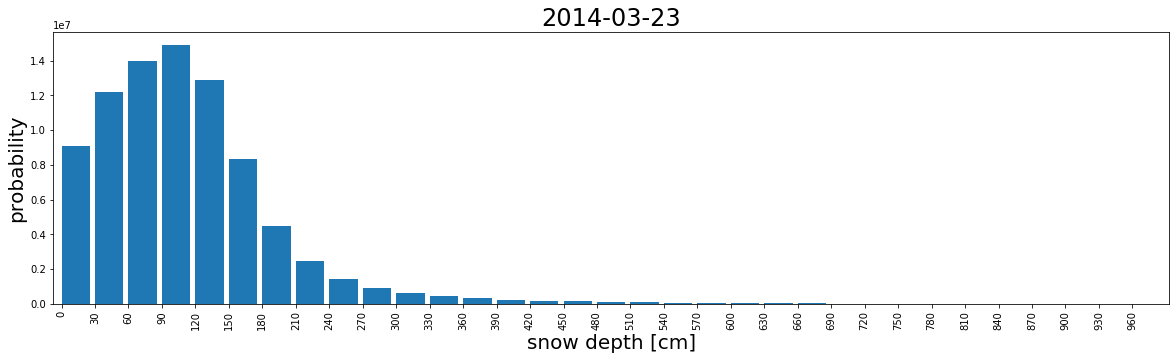

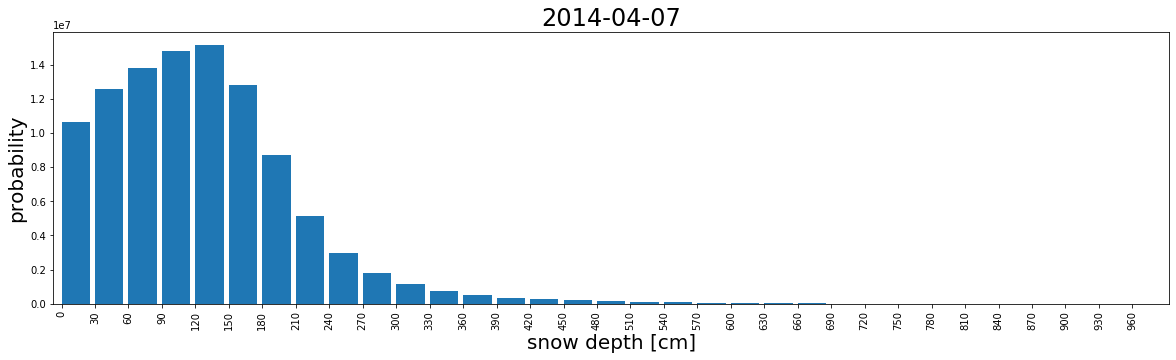

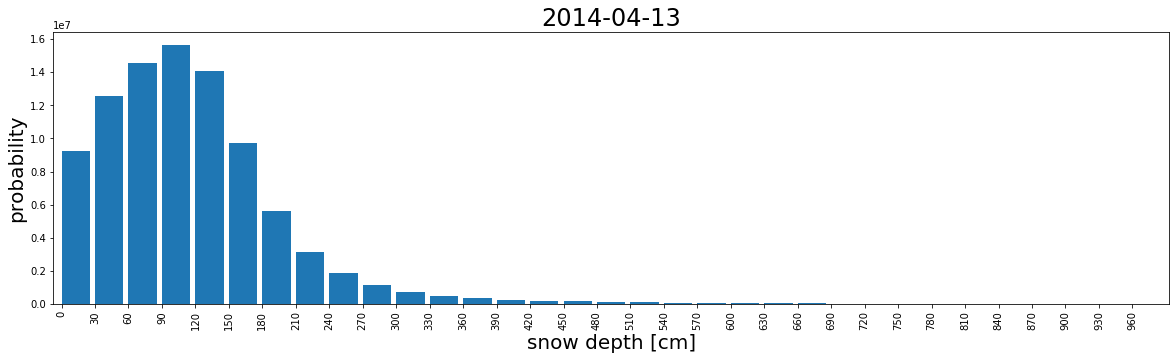

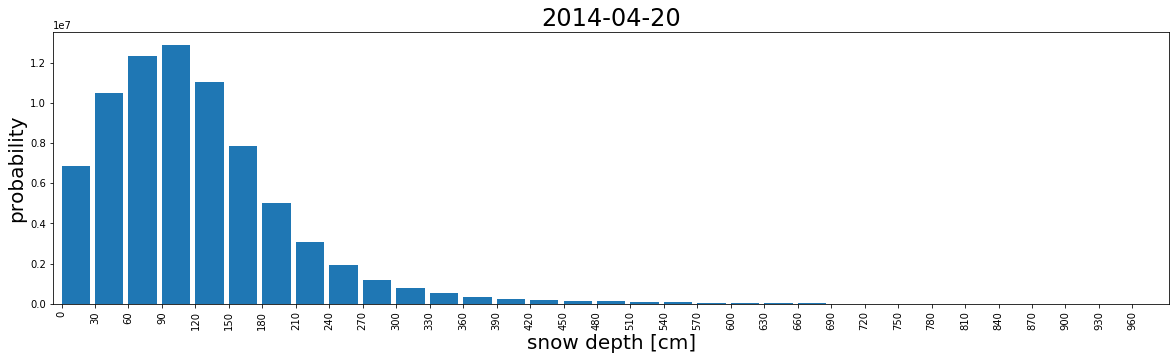

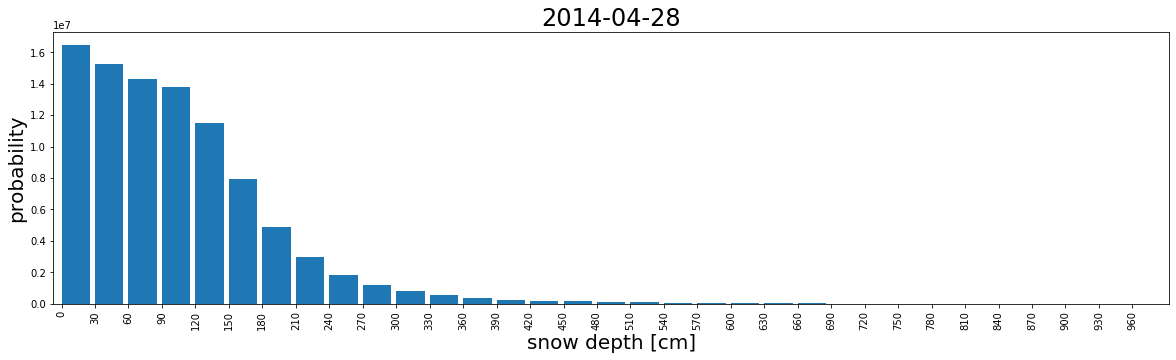

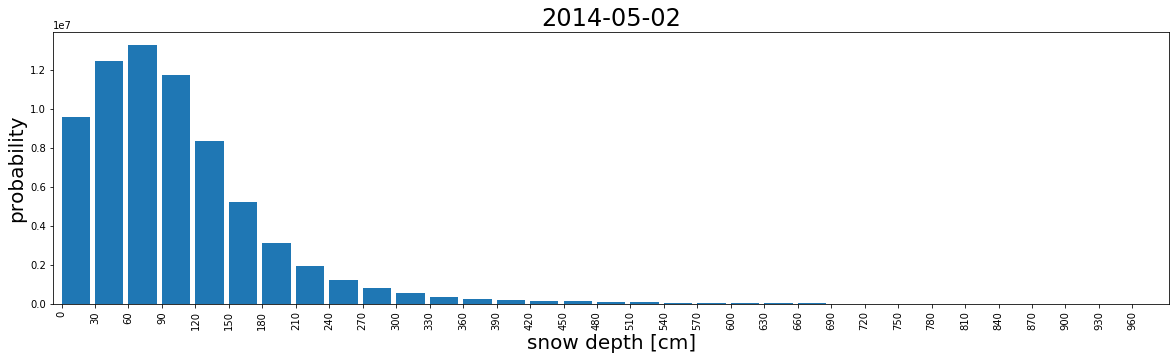

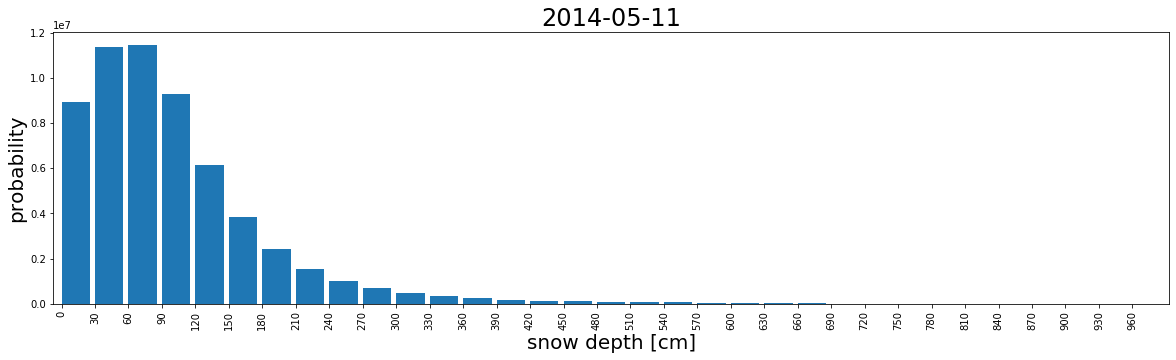

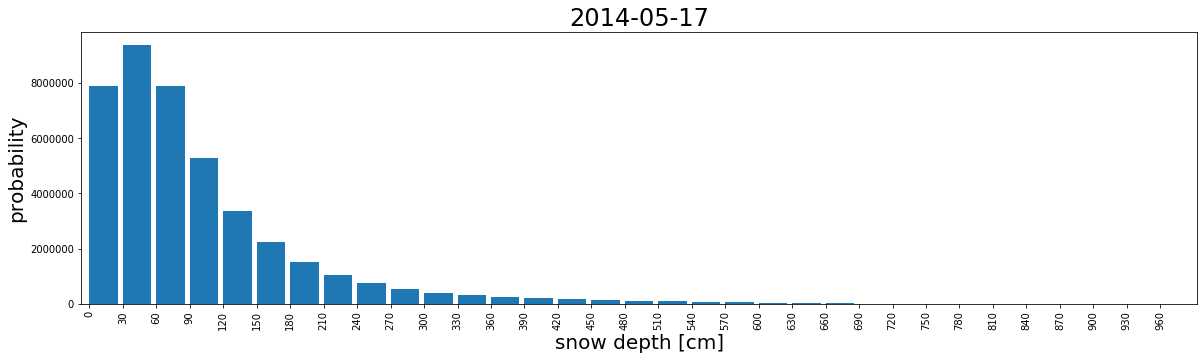

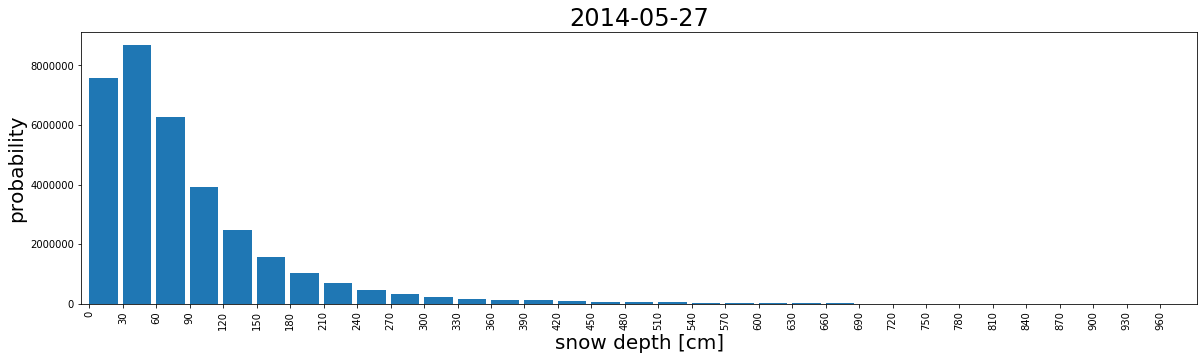

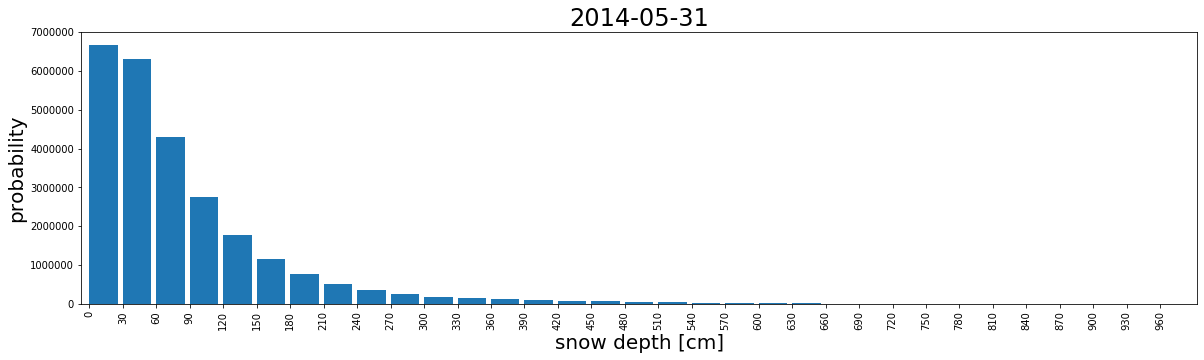

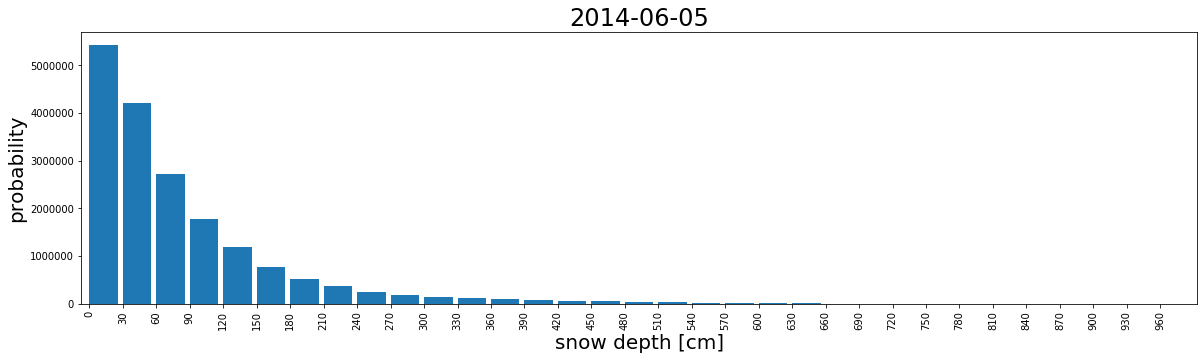

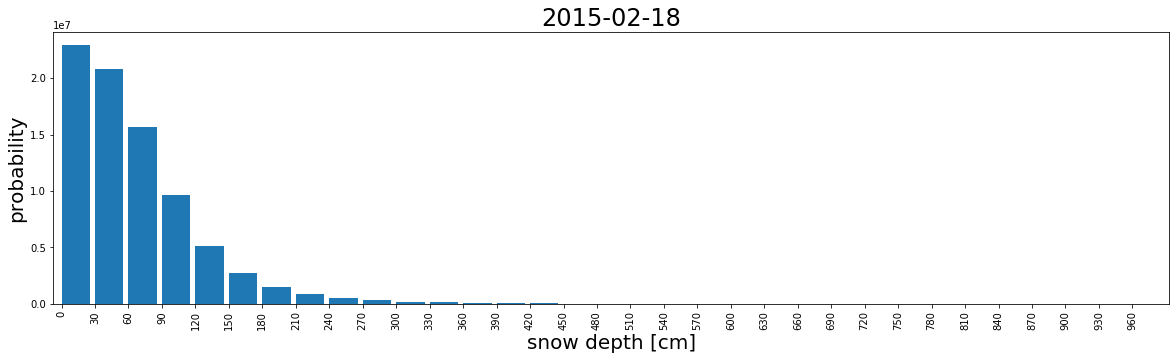

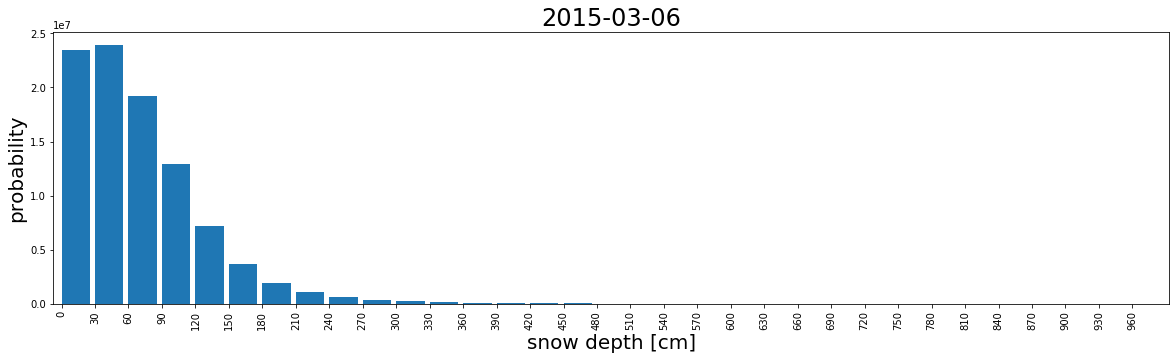

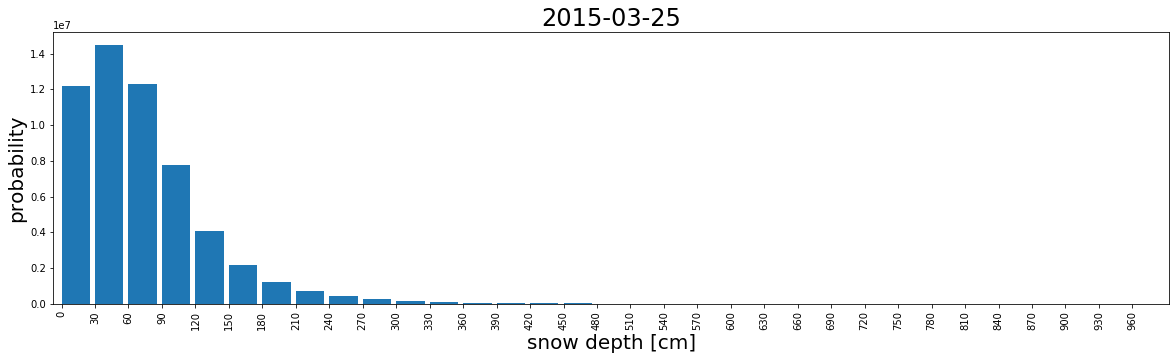

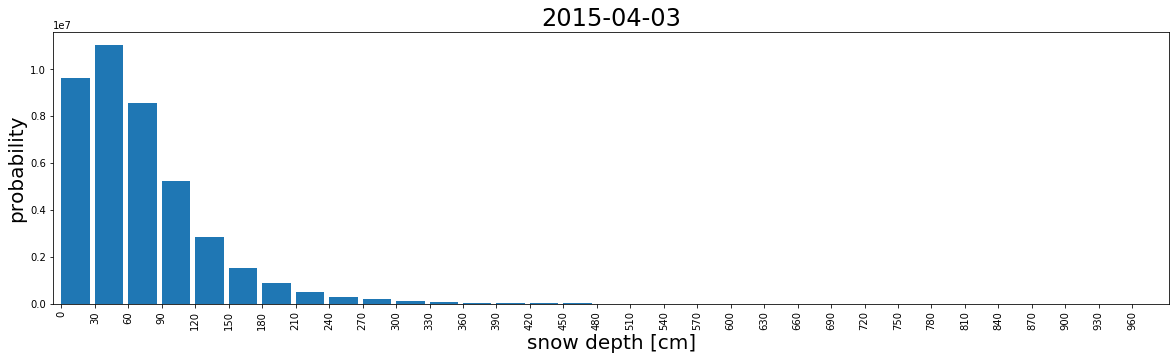

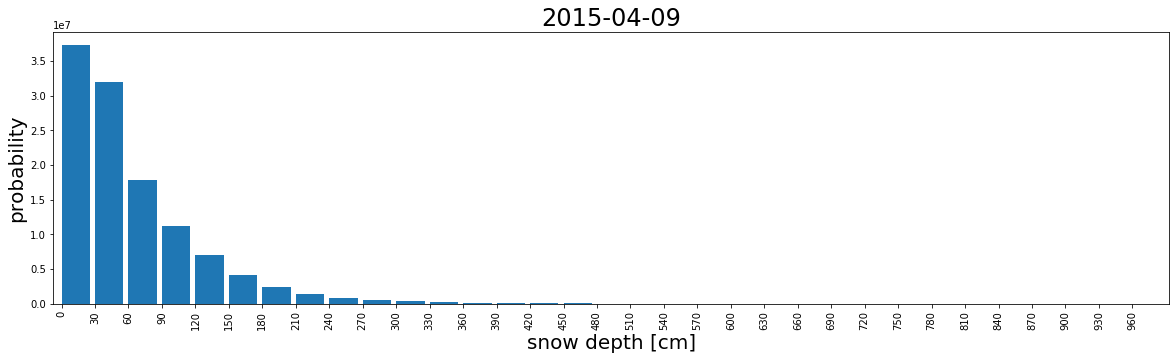

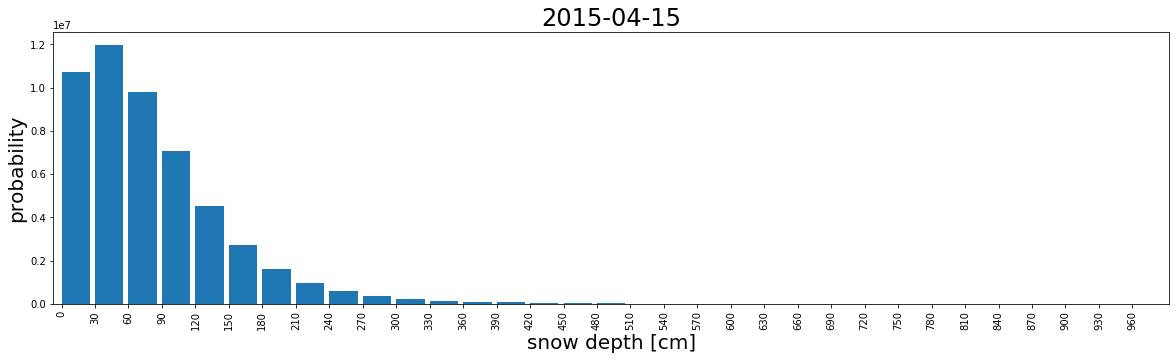

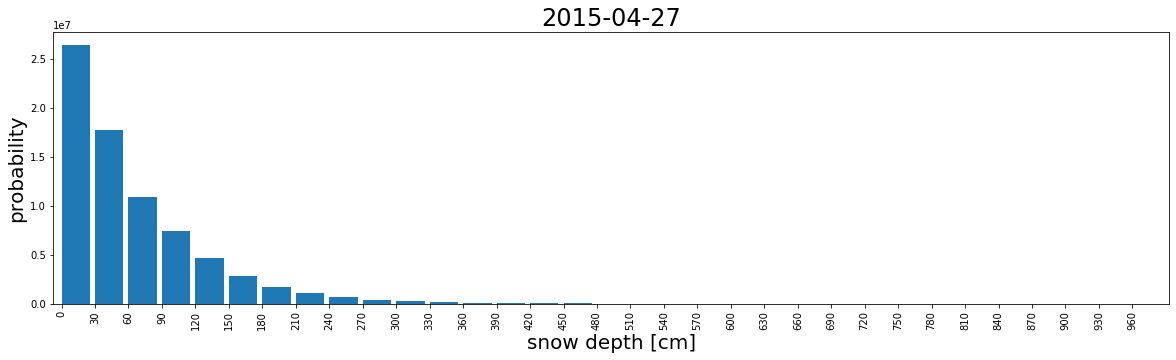

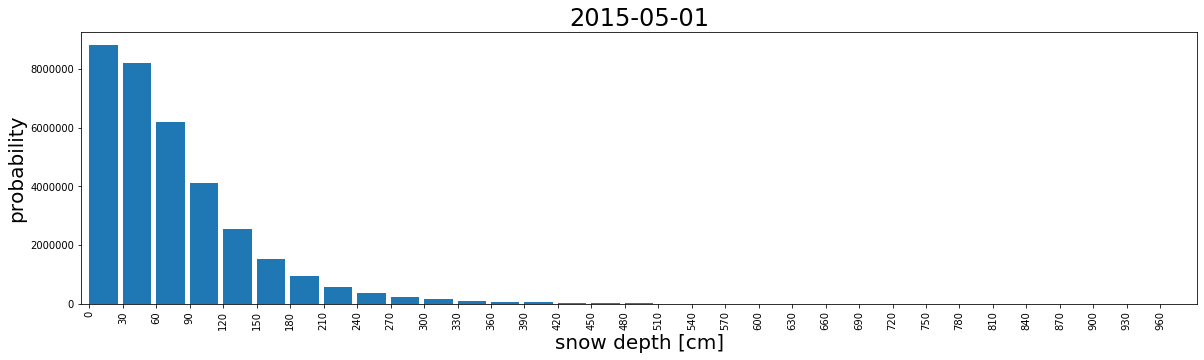

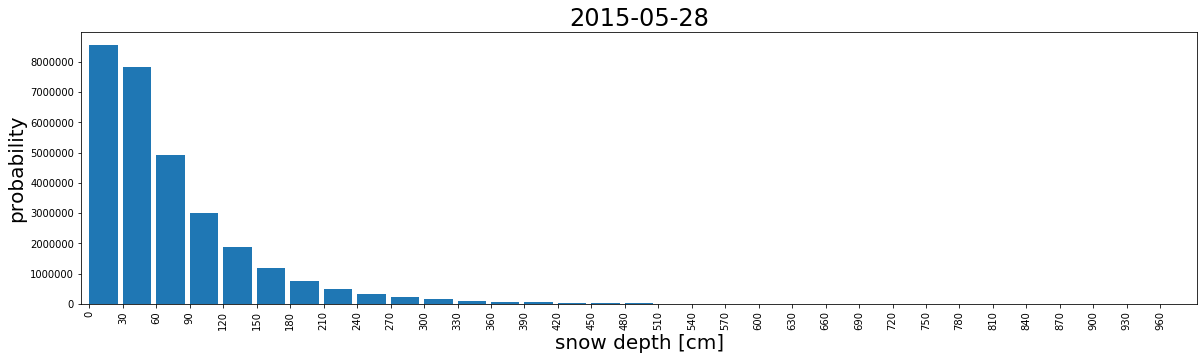

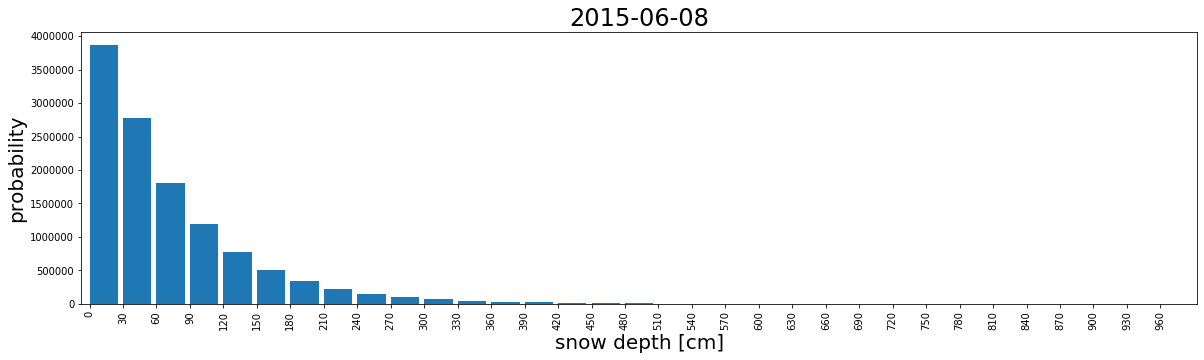

In [67]:
#plot histograms from df_h

fs_titles = 24
fs_labels = 24
fs_axes = 20
fs_text = 20
fs_legend = 20


for column in df_h:
#     print((str(column))
#     print(df_h[column])
    plt.figure(figsize=(20,5))
    df_h[column].plot.bar(width=0.85, align='edge')
    plt.title(str(column), fontsize=fs_titles)
    plt.xlabel('snow depth [cm]', fontsize=fs_axes); plt.ylabel('probability', fontsize=fs_axes)

In [ ]:
#example dataframe..
df = pd.DataFrame()
df['lidar flight'] = [ 2013 , 2014 , 2015] 
df['mean'] = ['5','5','5']
df['std'] = ['5','5','5']
df['min'] = ['5','5','5']
df['max'] = ['5','5','5']
df['#pixels'] = ['5','5','5']
df.set_index('lidar flight', inplace=True)
df

In [ ]:
for f in sorted(flist):
    d = io.imread(f) #is numpy array 
    print(f, d.shape)